In [21]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
# can also use adam optimizer for descent later

In [22]:
base_model = tf.keras.applications.InceptionV3(include_top=True)

In [23]:
# layer to run gradients on 
name = 'mixed10'

layer = base_model.get_layer(name).output

In [24]:
deepdream_model = tf.keras.Model(inputs=base_model.input, outputs=layer)

In [25]:
original_img = tf.keras.preprocessing.image.load_img(r'/home/shree/Documents/cat.jpg', target_size=(299, 299))
original_img = np.array(original_img)
target_img = tf.keras.preprocessing.image.load_img(r'/home/shree/Documents/tiger.jpg', target_size=(299, 299))
target_img = np.array(target_img)

In [26]:
loss_func = tf.keras.losses.MeanSquaredError()
target_activation = tf.round(deepdream_model.predict(tf.expand_dims(tf.keras.applications.inception_v3.preprocess_input(target_img), axis=0)))
def loss_calc(image, model):
  image = tf.expand_dims(image, axis=0)
  layer_activation = model(image)
  return loss_func(target_activation, layer_activation)

1/1 [==============================] - 2s 2s/step


In [27]:
@tf.function
def run_epoch(model, image, lr):
    with tf.GradientTape() as tape:
      tape.watch(image)
      loss = loss_calc(image, model) 

    gradient = tape.gradient(loss, image)
    gradient /= tf.math.reduce_std(gradient)  

    image -= gradient * lr
    image  = tf.clip_by_value(image, -1, 1)

    return loss, image

In [33]:
def deep_dream(model, image, steps, lr):
  image = tf.keras.applications.inception_v3.preprocess_input(image)

  for step in range(steps):
    loss, image = run_epoch(model, image, lr)
    
    if step % 120 == 0:
      plt.imshow(deprocess(image))
      plt.show()
      print (f"step {step}, loss {loss}")

  plt.figure(figsize=(12,12))
  plt.imshow(deprocess(image))
  plt.show()

  return deprocess(image).numpy()

In [34]:
def deprocess(image):
  image = 255*(image + 1.)/2.
  return tf.cast(image, tf.uint8)

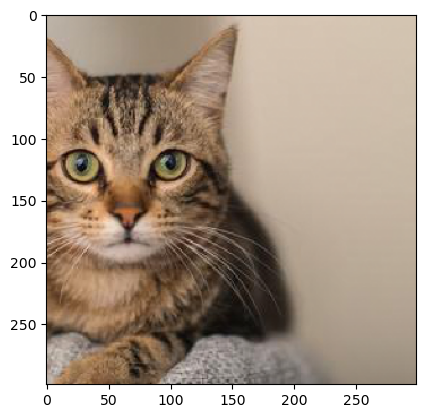

step 0, loss 0.6391856670379639


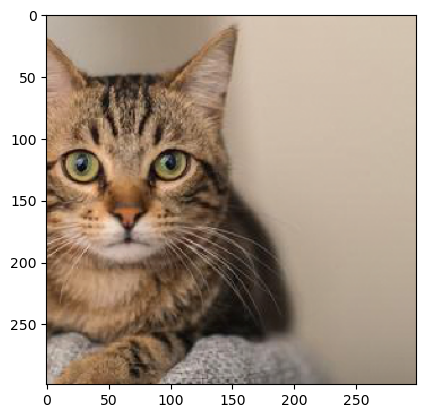

step 120, loss 0.2291523516178131


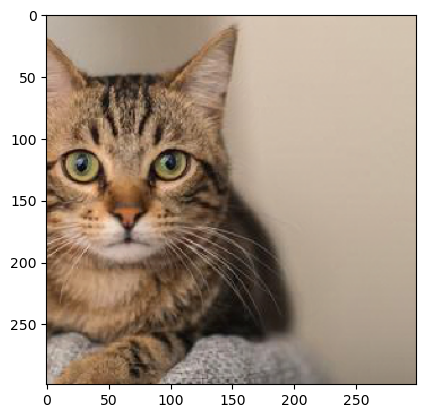

step 240, loss 0.18015886843204498


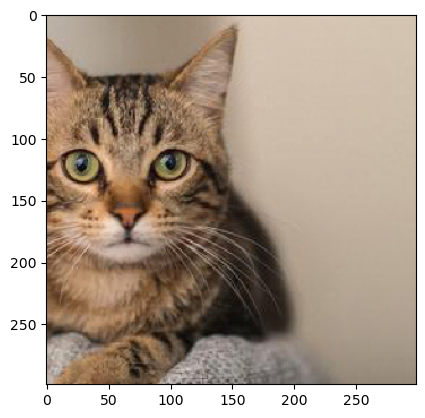

step 360, loss 0.133965402841568


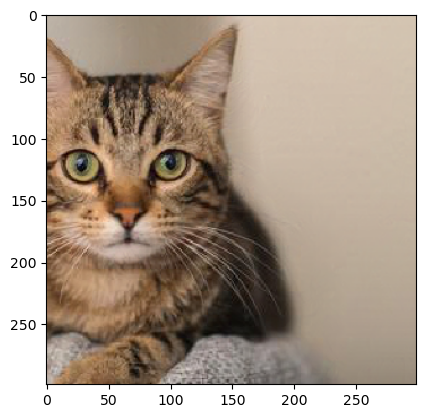

step 480, loss 0.10964829474687576


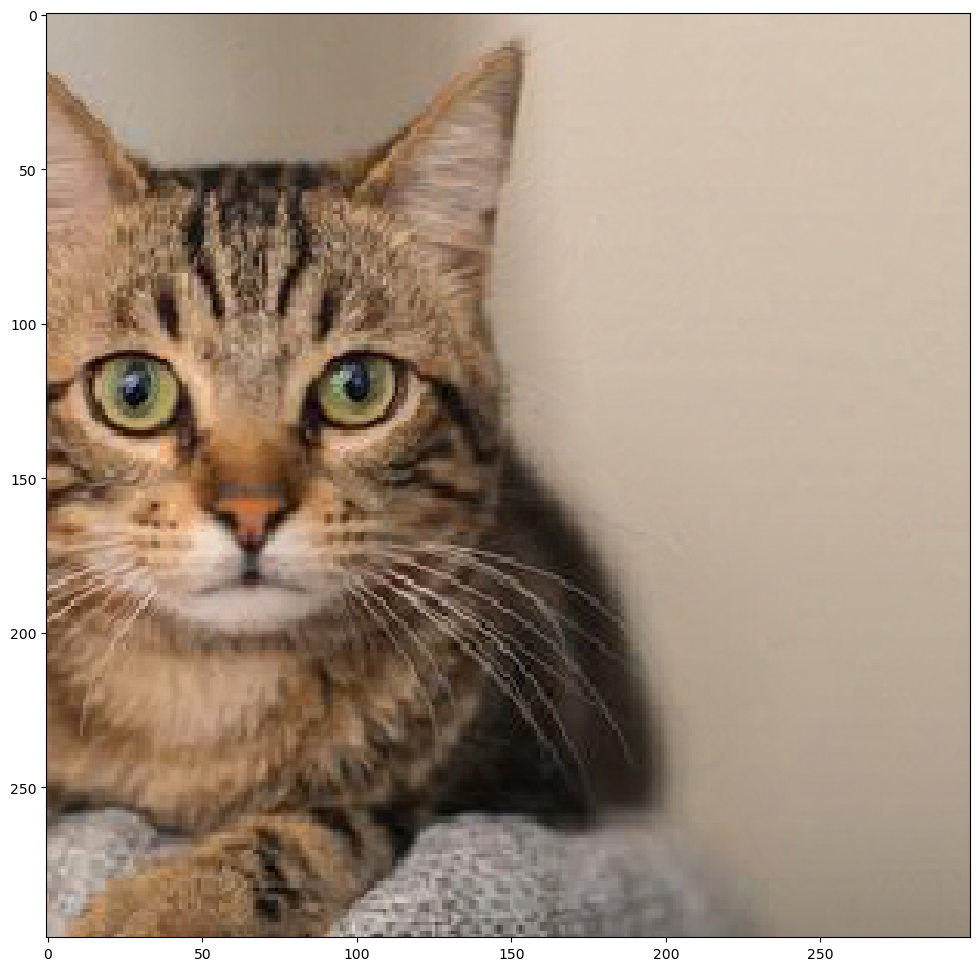

In [35]:
dream_img = deep_dream(deepdream_model, original_img, 500, 1e-4)

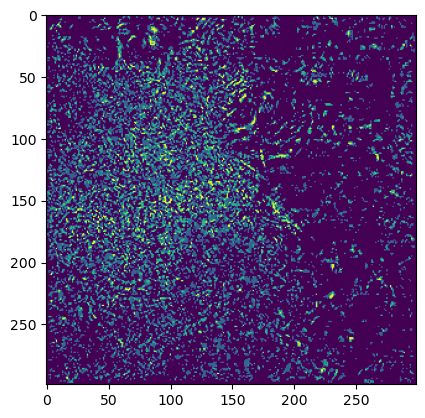

In [39]:
plt.imshow(abs(original_img-dream_img).mean(axis=-1))
plt.show()

In [40]:
new    = base_model.predict(tf.expand_dims(tf.keras.applications.inception_v3.preprocess_input(dream_img), axis=0))
old    = base_model.predict(tf.expand_dims(tf.keras.applications.inception_v3.preprocess_input(original_img), axis=0))
target = base_model.predict(tf.expand_dims(tf.keras.applications.inception_v3.preprocess_input(target_img), axis=0))

1/1 [==============================] - 0s 173ms/step


In [41]:
print(new.argmax(), old.argmax(), target.argmax())
print(new[0,new.argmax()], target[0,target.argmax()])

292 281 292
0.65964866 0.6843231
